### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dynamic Time Warping

In [2]:
def dynamic_time_warping(a, b):
    n = len(a)
    m = len(b)

    distances_row_1 = np.zeros(m)
    distances_row_2 = np.zeros(m)

    distances_row_1[:] = np.cumsum((a[0] - b[:]) ** 2)

    for i in range(1, n):
        distances_row_2[0] = (a[i] - b[0]) ** 2 + distances_row_1[0]
        for j in range(1, m):
            distances_row_2[j] = (a[i] - b[j]) ** 2 + min(distances_row_2[j - 1], min(distances_row_1[j - 1], distances_row_1[j]))
        distances_row_1[:] = distances_row_2

    return np.sqrt(distances_row_1[m - 1])

## Principal Component Analysis

In [3]:
def principal_component_analysis(df, k):
    # zero-mean the data
    df = df - df.mean()
    
    # compute eigenvalues from the covariance matrix C = 1/N * X^T * X
    covariance_matrix = 1/ df.shape[0] * df.T @ df
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # sort the eigenvalues and corresponding eigenvectors
    sorted_indices = np.flip(np.argsort(eigenvalues))
    eigenvectors = eigenvectors[:, sorted_indices]

    return eigenvectors[:,:k]
    

def apply_principal_component_analysis(df, eigenvectors):
    # zero-mean the data
    df = df - df.mean()

    # apply the eigenvectors
    projected_data = df @ eigenvectors

    return pd.DataFrame(projected_data@eigenvectors.T),pd.DataFrame(projected_data),pd.DataFrame(df)

## Familiarization

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [4]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [5]:
def visualize_sensor_data(df, window=None, sensors=None, normalized=False):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        sensor_data = df[sensor][start_index:end_index]
        if normalized:
            sensor_data = sensor_data - sensor_data.mean()
        plt.plot(df['Timestamp'][start_index:end_index], sensor_data, label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

C:\Users\andrei\PycharmProjects\pythonProject4\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


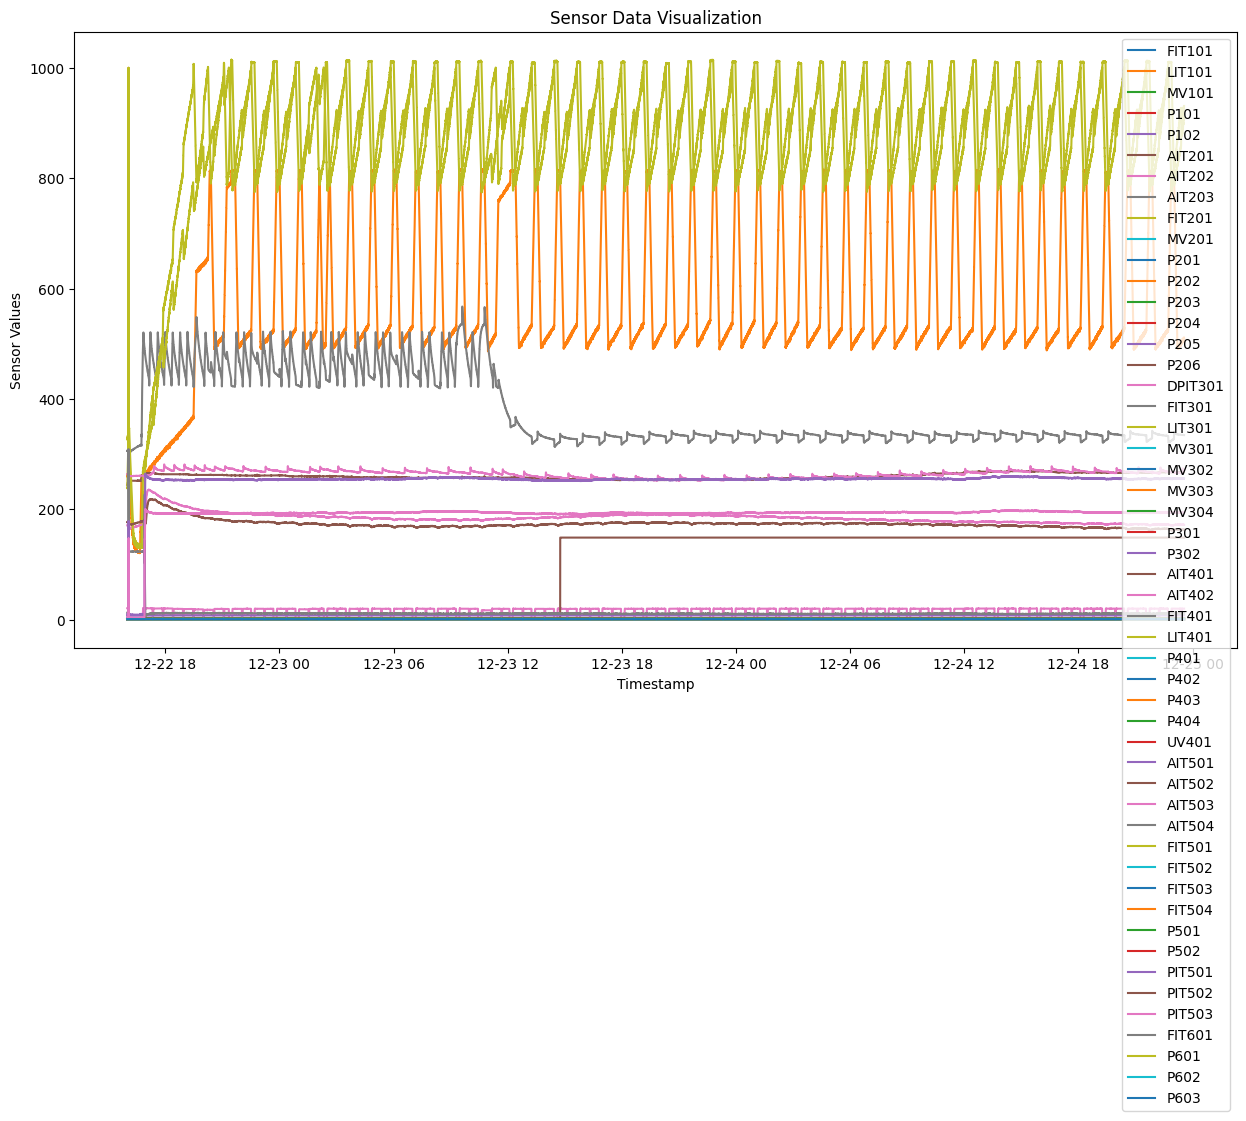

In [6]:
# Visualize first 200000 measurements from each sensor
visualize_sensor_data(train_data, window=(0, 200_000))

#### Types of signals
From the visualization, we can see there are 2 types of signals based on their values: continuously-valued and discretely-valued.
An example of a signal with continuous values can be seen in the following cell.

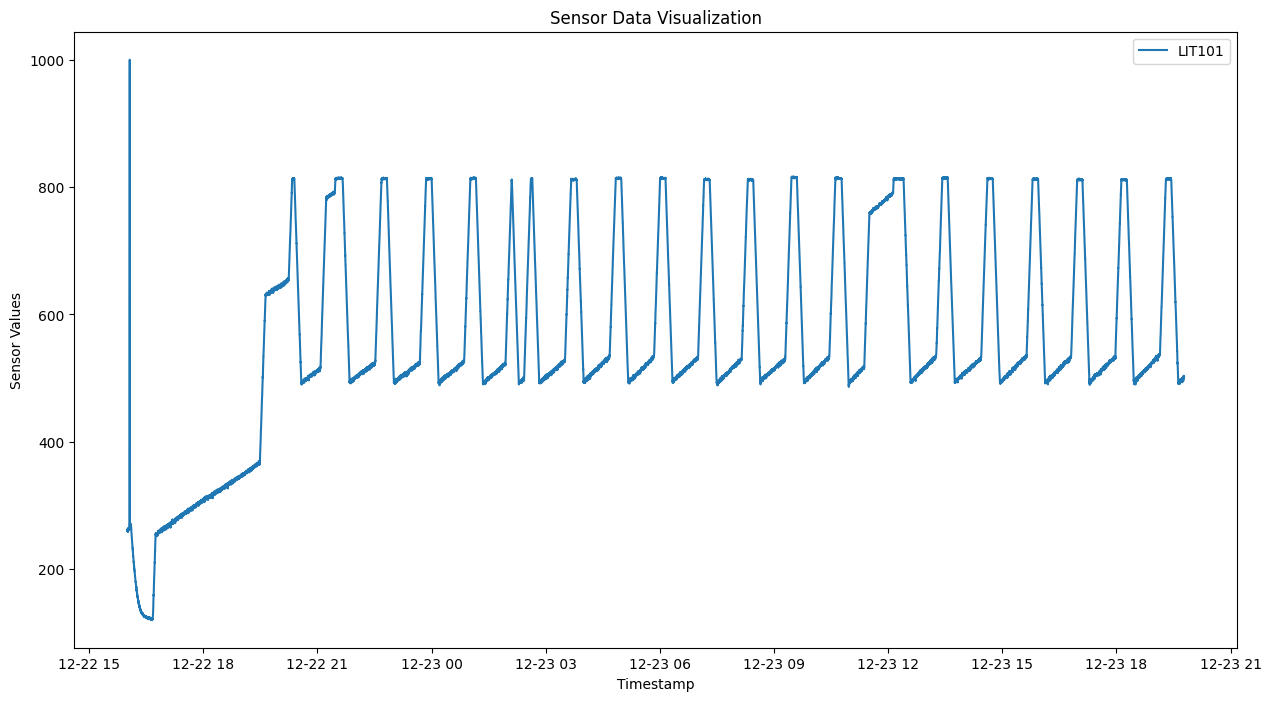

In [7]:
visualize_sensor_data(train_data, window=(0, 100_000), sensors=["LIT101"])

An example of a signal with discrete values can be seen in the following cell.

Measurements from MV101 take values from [0 1 2]


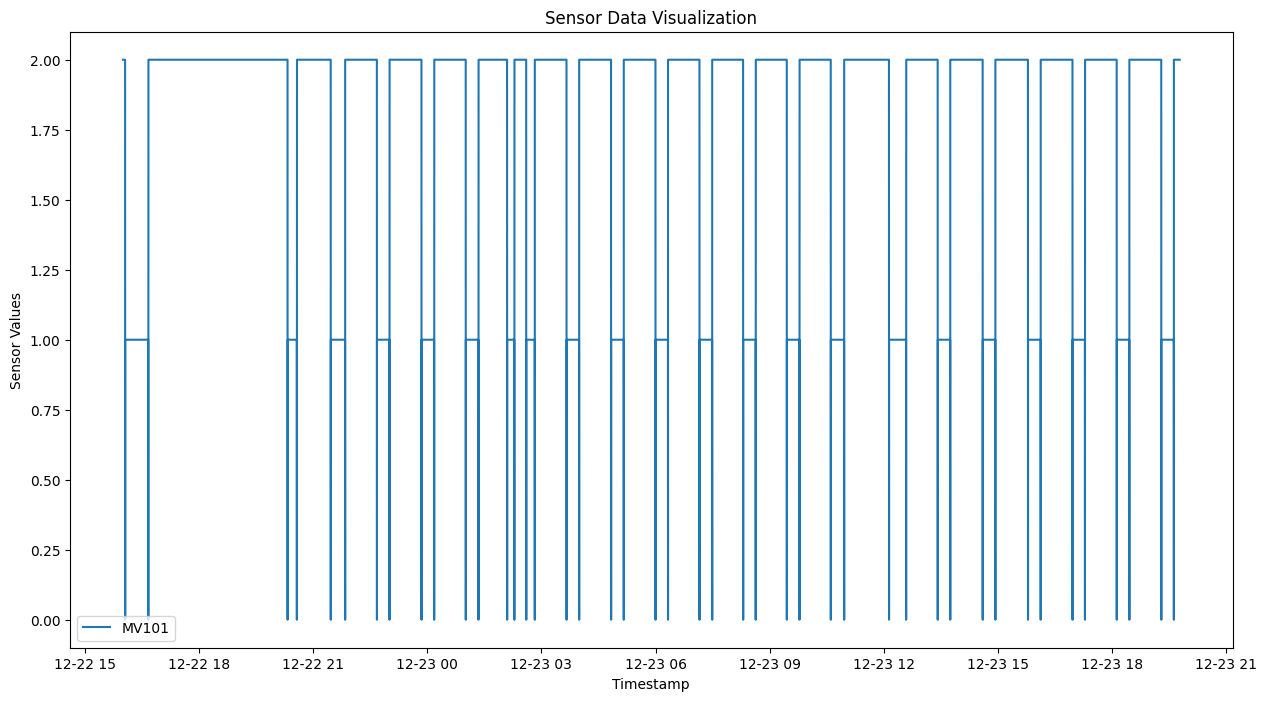

In [8]:
MV101_values = np.unique(train_data['MV101'])
print(f'Measurements from MV101 take values from {MV101_values}')
visualize_sensor_data(train_data, window=(0, 100_000), sensors=["MV101"])

#### Are the signals correlated? Do they show cyclic behavior?

Yes, we can see that some signals are correlated, following almost the same pattern. For example, let's take a look at signals LIT301 LIT401, plotted below. We can see that they follow a similar pattern (overlapping in some cases), with values ranging from 750-1000. This can be explained by the fact that the signals have a similar name, suggesting their use may be for the same purposes.
The behavior shown by most continuous sensor values can be described as cyclic, with repeating values over time. For example, referring back to LIT301, we can see that every (approximately) hour and 15 minutes, the signal reads the same value (when functioning normally).

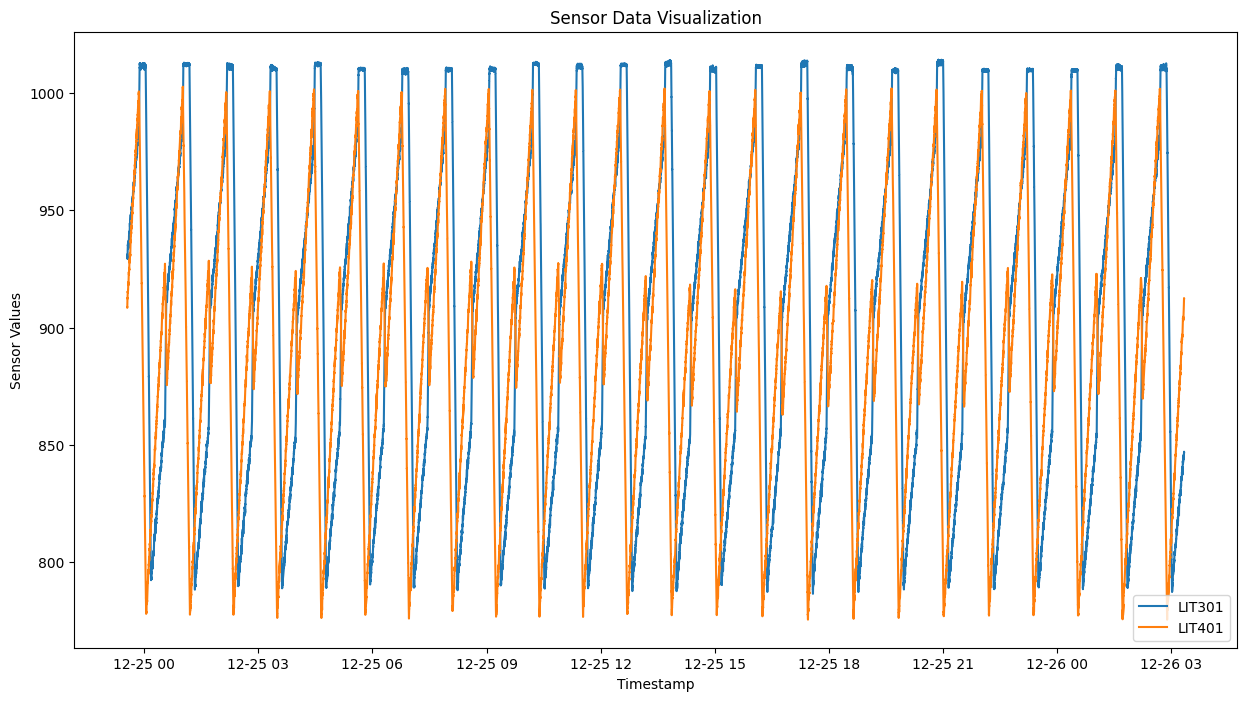

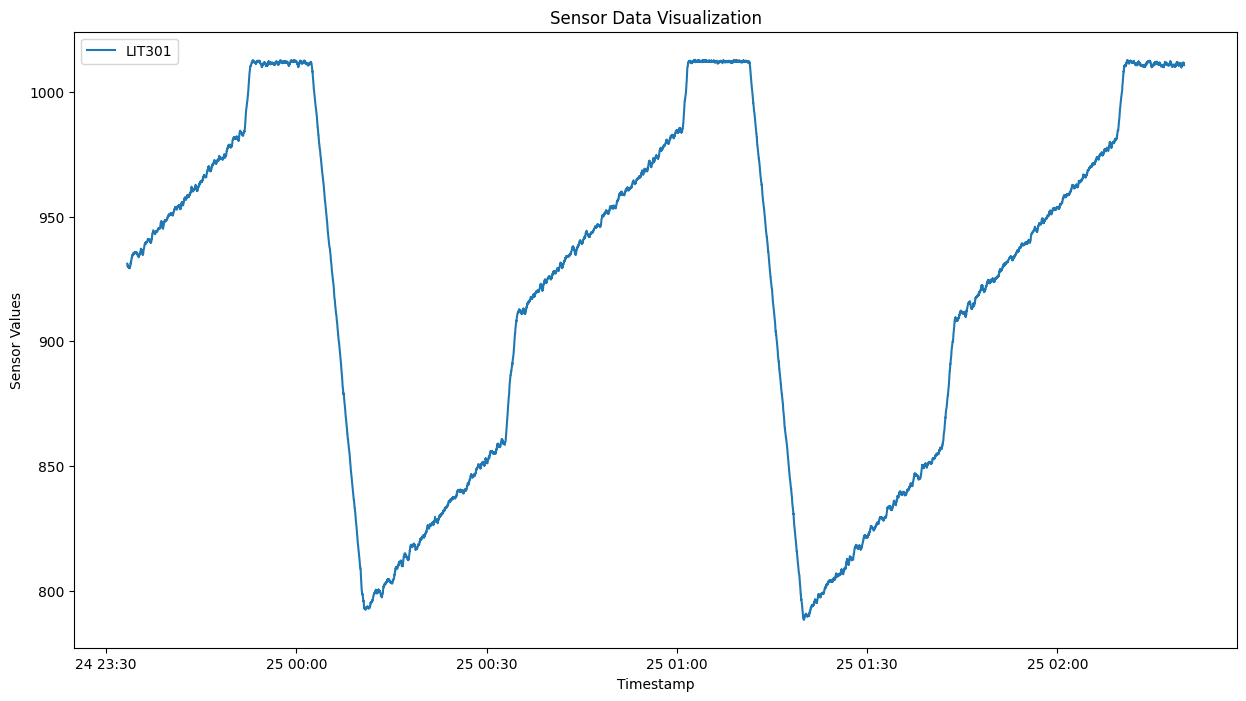

In [9]:
visualize_sensor_data(train_data, window=(200_000,300_000), sensors=["LIT301","LIT401"])
visualize_sensor_data(train_data, window=(200_000,210_000), sensors=["LIT301"])

## DTW-based anomaly detection
Below we are running an experiment on a single sensor, AIT504. First, we are visualizing some normal behaviour of the signal. For that purpose, we are ignoring the beginning of the series which shows some anomalous behaviour. That behavior can be explained by the sensor booting up and needing to calibrate itself. 

Then, we are taking 4 windows representative of this pattern of size 500 each. We chose these windows, because their means are somewhat different (11, 10.5, 12, 13.5), and because of that we can cover most typical behaviors of the sensor.

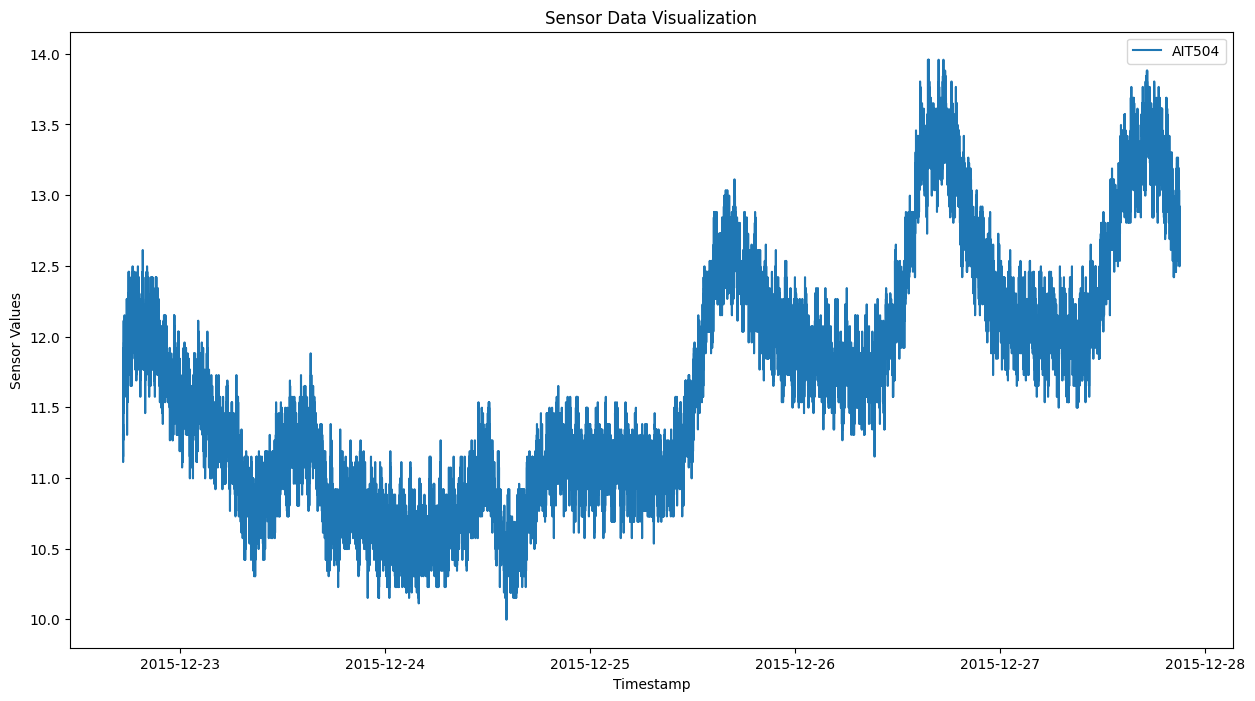

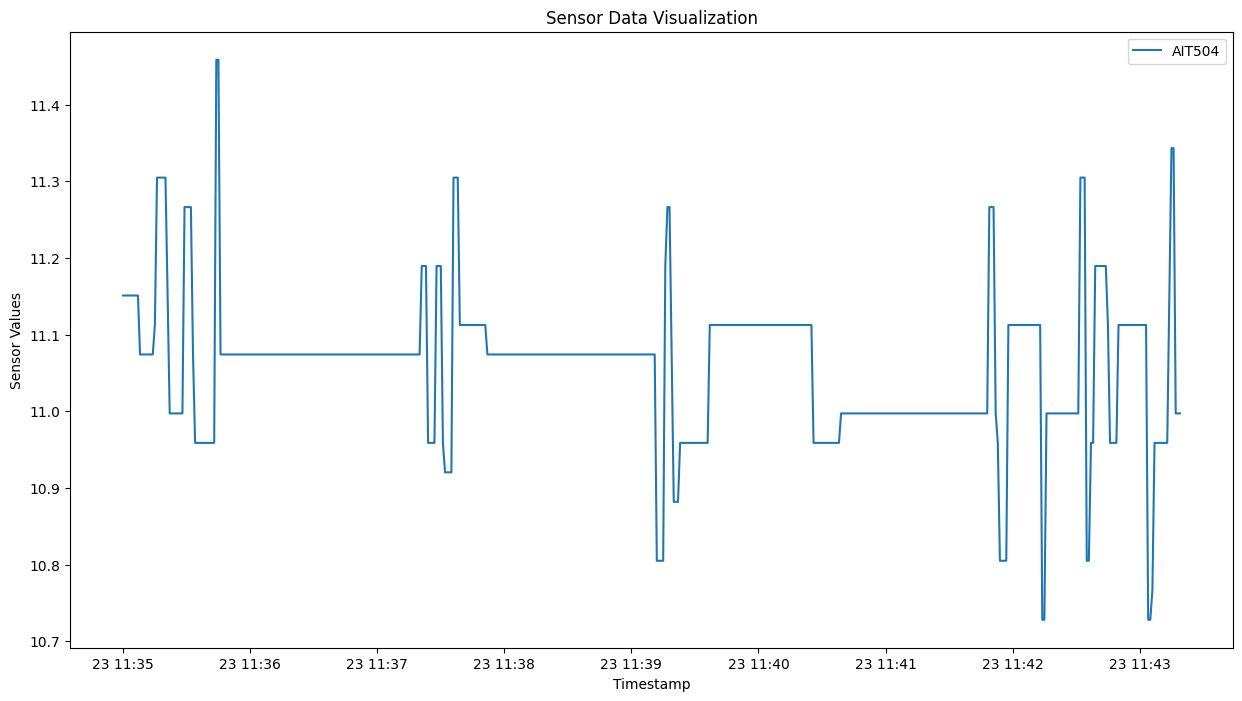

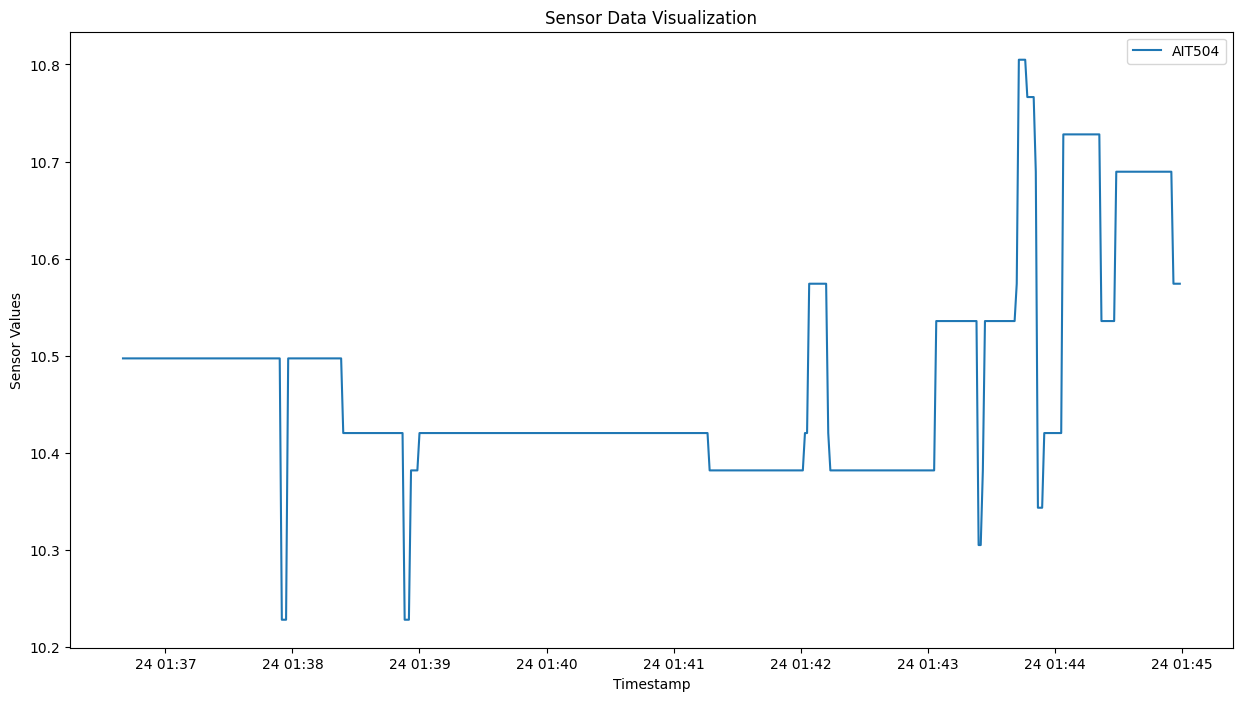

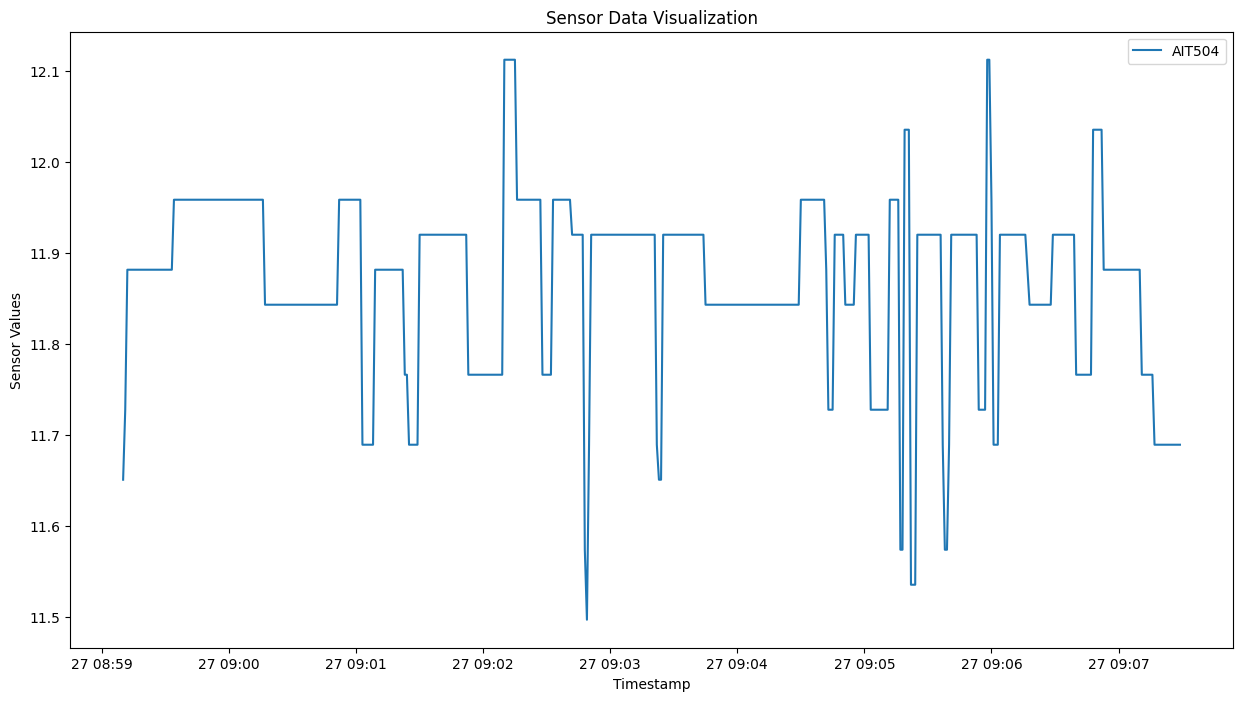

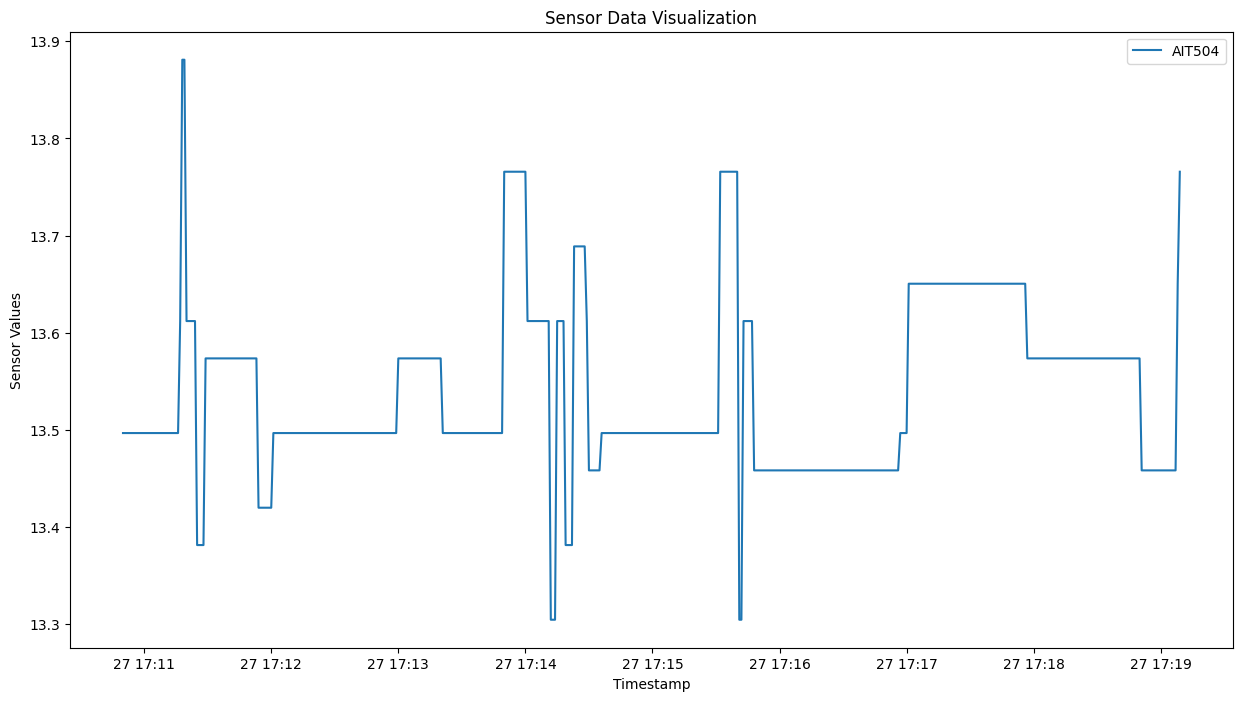

In [10]:
# visualize sensor data
visualize_sensor_data(train_data, window=(5000,450_000),sensors=['AIT504'])

aitTraining = train_data["AIT504"].values
aitTest = test_data['AIT504'].values

# data normalization
aitTraining = (aitTraining - np.mean(aitTraining)) / np.std(aitTraining)
aitTest = (aitTest - np.mean(aitTest)) / np.std(aitTest)

# define the representative windows
representative_windows = np.array([
        aitTraining[70_500:71_000],
        aitTraining[121_000:121_500],           
        aitTraining[406_750:407_250],
        aitTraining[436_250:436_750]
])

# visualize the representative windows
visualize_sensor_data(train_data, window=(70_500,71_000), sensors=['AIT504']) # window 1
visualize_sensor_data(train_data, window=(121_000,121_500), sensors=['AIT504']) #window 2
visualize_sensor_data(train_data, window=(406_750,407_250), sensors=['AIT504']) # window 3
visualize_sensor_data(train_data, window=(436_250,436_750), sensors=['AIT504']) # window 4

### Identifying anomalies using DTW
To identify anomalies in the test data, we are first setting a threshold on the residual. By setting the threshold as residual mean + 3 * standard deviation, we assume that 99.7% of the train data is normal.

In [11]:
# This code cell below should run in ~1 min

# TODO REMOVE
from tqdm import tqdm

# randomly sample 100 sliding windows from the train data (stride is 250)
residuals = []
train_windows = np.lib.stride_tricks.sliding_window_view(aitTraining[5000 : 450_000], window_shape=500)[::250]
random_windows = train_windows[np.random.choice(train_windows.shape[0], size=100, replace=False)]

for train_window in tqdm(random_windows):
    # find the closest representative window
    temp = np.zeros(representative_windows.shape[0])
    for k, representative_window in enumerate(representative_windows):
        temp[k] = dynamic_time_warping(representative_window, train_window)     
    residuals.append(np.amin(temp))
residuals = np.array(residuals)

# set the threshold
# we assume the distribution of residuals is normal
# as such, we can use the 67-95-99.7 rule to define a proper threshold
threshold = np.mean(residuals) + 3 * np.std(residuals)
print(f'Threshold is {threshold}')

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]

Threshold is 2.0237276088614853


#### Test data 

**N.B** : We will use a (somewhat) reduced sample of the test data in order to save time, as an entire run of the data would take longer than 15 minutes.

Now, let's have a look at the test data. As we can see in the plot below, there are 2 major peaks that we wish to identify as anomalies.


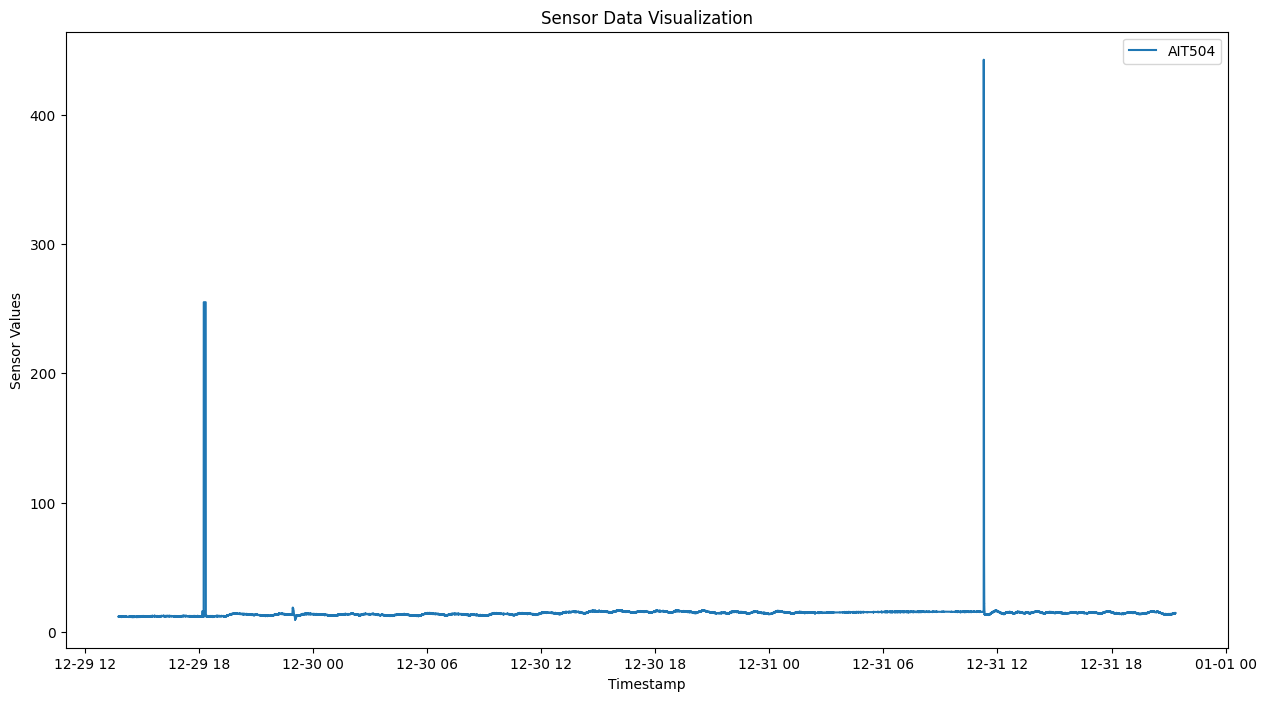

In [12]:
visualize_sensor_data(test_data, window=(100_000, 300_000), sensors=['AIT504'])

We have 400 tumbling test windows.


100%|██████████| 400/400 [04:09<00:00,  1.61it/s]


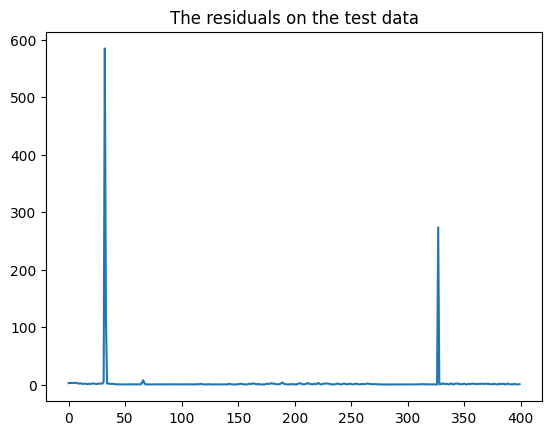

We found 28 anomalies.


In [13]:
# This code cell below should run in ~5 min

# use tumbling windows on test data for anomaly detection (stride is 500)
test_windows = np.lib.stride_tricks.sliding_window_view(aitTest[100_000 : 300_000], window_shape=500)[::500]
print(f'We have {test_windows.shape[0]} tumbling test windows.')

residuals = []
for test_window in tqdm(test_windows):
    # find the closest representative window
    temp = np.zeros(representative_windows.shape[0])
    for k, representative_window in enumerate(representative_windows):
        temp[k] = dynamic_time_warping(representative_window, test_window)
    residuals.append(np.amin(temp))
    
plt.plot(residuals)
plt.title('The residuals on the test data')
plt.show()

print(f'We found {np.count_nonzero(residuals > threshold)} anomalies.')

As we can see, the 2 peaks in the test data correspond to the 2 largest residuals in the plot above.

### What kind of anomalies do you expect to detect using DTW distances in this manner?

Using DTW distance, we should be able to detect contextual anomalies. When dealing with time series, we mark as anomalies groups of data points that deviate significantly from normal behaviour.

## PCA-based anomaly detection

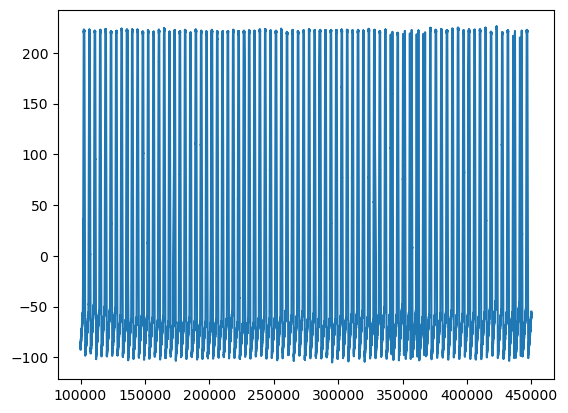

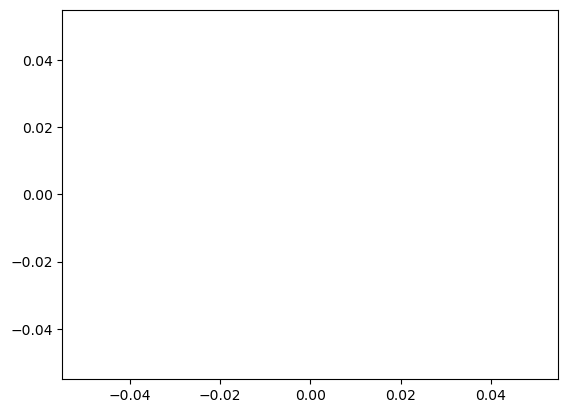

In [57]:
sensor_labels = train_data.columns[1:-1]
normal_train_data = train_data[100_000 : 450_001][sensor_labels]
# normalized in the PCA

eigenvectors = principal_component_analysis(normal_train_data, sensor_labels.size)
plt.plot((normal_train_data - normal_train_data.mean()).iloc[:, 1:2])
plt.show()

reconstructed_data = apply_principal_component_analysis(normal_train_data, eigenvectors.T)
plt.plot(reconstructed_data.iloc[:, 1:2])
plt.show()
# visualize_sensor_data(train_data, window=(100_000, 450_000), normalized=True)

#### For starters, we will define a function that uses PCA to remove anomalies from the input data using a specified training dataset.

In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def principal_component_analysis(df, k):
    eigenvectors = np.zeros(shape=(df.shape[1], k))
    df = df.values.T.astype(float)
    
    #Zero-mean the data
    for i in range(df.shape[0]):
        df[i] = df[i] - np.mean(df[i])
        
    #Create covarance matrix
    cov = 1 / df.shape[0] * df @ df.T

    #Extract eigenvalues and eigenvectors
    evl, evec = np.linalg.eig(cov)
    d = {}
    for i in range(evl.size):
        d[evl[i]] = evec[:,i]
    
    #Sort by eigenvalues decreasingly
    evls = np.sort(np.unique(evl))[::-1]
    
    #Take first k eigenvectors
    for i in range(k):
        eigenvectors[:,i] = d[evls[i]]
    
    return eigenvectors  
    

def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))
    means = np.zeros(df.shape[0])
    df = df.T.values.astype(float)
    
    #zero-mean data again
    for i in range(df.shape[0]):
        means[i] = np.mean(df[i])
        df[i] = df[i] - means[i]

    df = df.T
    #project data
    projected_data = df@eigenvectors
    
    #reproject it back
    reprojected_data = projected_data@eigenvectors.T
    
    # return the projected data, reprojected data and the normalized data
    return pd.DataFrame(reprojected_data),pd.DataFrame(projected_data),pd.DataFrame(df)



# Applies PCA for anomaly detection on the test data using eigenvectors from the training data
# @param train training data - we assume it is a pandas DataFrame that includes Timestamp and Normal/Attack fields
# @param test test data - we assume it is a pandas DataFrame that includes Timestamp and Normal/Attack fields
# @param k number of principal components
# @param threshold the threshold for anomaly removal
# @param plotSteps plot intermediary steps
def PCA_for_anomaly_detection(train,test,k,threshold,plotSteps=True):
    
    #remove Timestamp and Normal/Attack fields from DataFrames
    test_without_ts = pd.DataFrame(test.values[:, 1:-1])
    train_without_ts = pd.DataFrame(train.values[:, 1:-1])
    
    print("fixed dfs")
    #apply Principal Component Analysis
    eig = principal_component_analysis(train_without_ts,k)
    reprojData,projData,normData = apply_principal_component_analysis(test_without_ts,eigenvectors=eig)
    
    print("applied pca")
    if plotSteps:
        reprojData.plot()
        plt.show()
        normData.plot()
        plt.show()
    
    # use Mean-Squared Error as a metric for anomaly removal
    banana = np.zeros(reprojData.shape[0])
    for i in tqdm(range(reprojData.shape[0])):
        banana[i] = np.mean((reprojData.iloc[i]-normData.iloc[i])**2)
    
    print("calculated mse")
    #Show residuals and threshold
    if plotSteps:
        plt.plot(banana)
        plt.axhline(y=threshold,color='red',linestyle='--')
    
        
    # Iterate through the data and choose datapoints where the metric is below the threshold
    indices = []
    for i in tqdm(range(normData.shape[0])):
        if banana[i]<threshold:
            indices.append(i)
    
    # return the DataFrame with anomalies removed
    return test.iloc[indices]


fixed dfs
applied pca


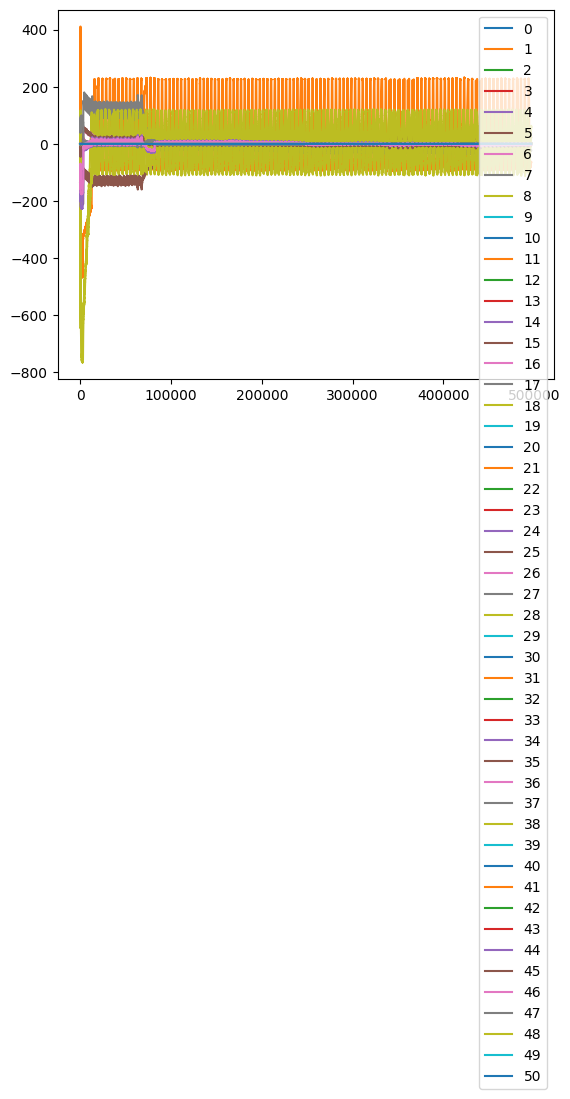

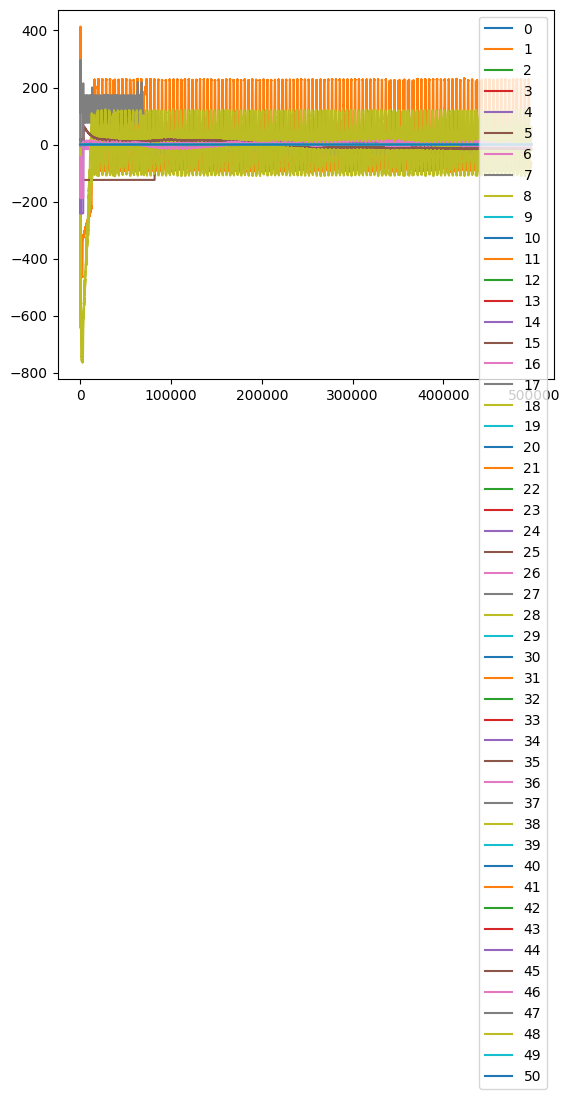

100%|██████████| 496800/496800 [00:56<00:00, 8778.83it/s]


calculated mse


100%|██████████| 496800/496800 [00:00<00:00, 4933283.68it/s]


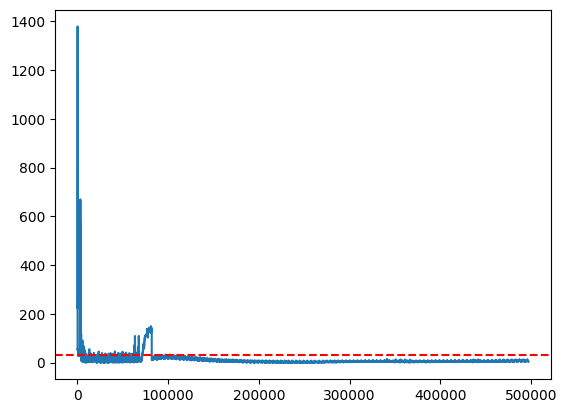

In [15]:
# This code cell should run in ~5-6 minutes worst-case
var = PCA_for_anomaly_detection(train_data,train_data,5,30,True)

Now, let us compare the difference between the data with anomalies removed (first plot) and the data without.

In [16]:
# We remove the legend the visualize_sensor_data method such that we can properly see the difference between plots.

def visualize_sensor_data(df, window=None, sensors=None, normalized=False):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        sensor_data = df[sensor][start_index:end_index]
        if normalized:
            sensor_data = sensor_data - sensor_data.mean()
        plt.plot(df['Timestamp'][start_index:end_index], sensor_data, label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    #plt.legend()

    plt.show()

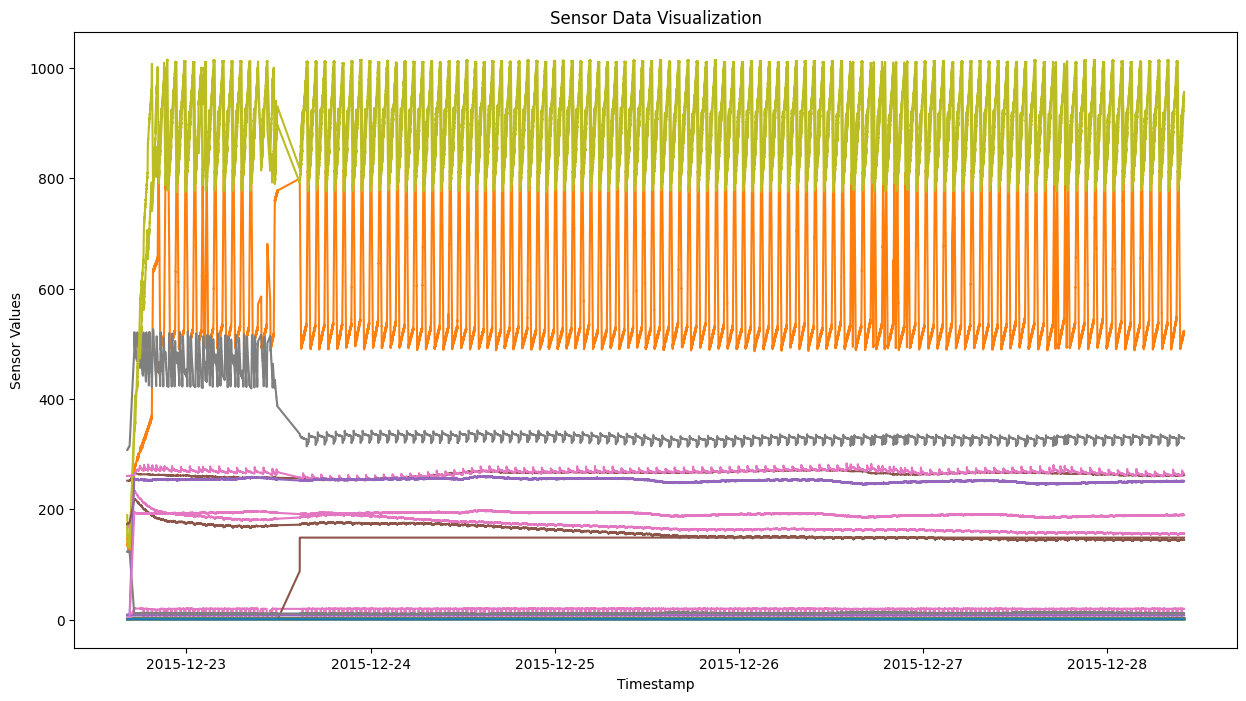

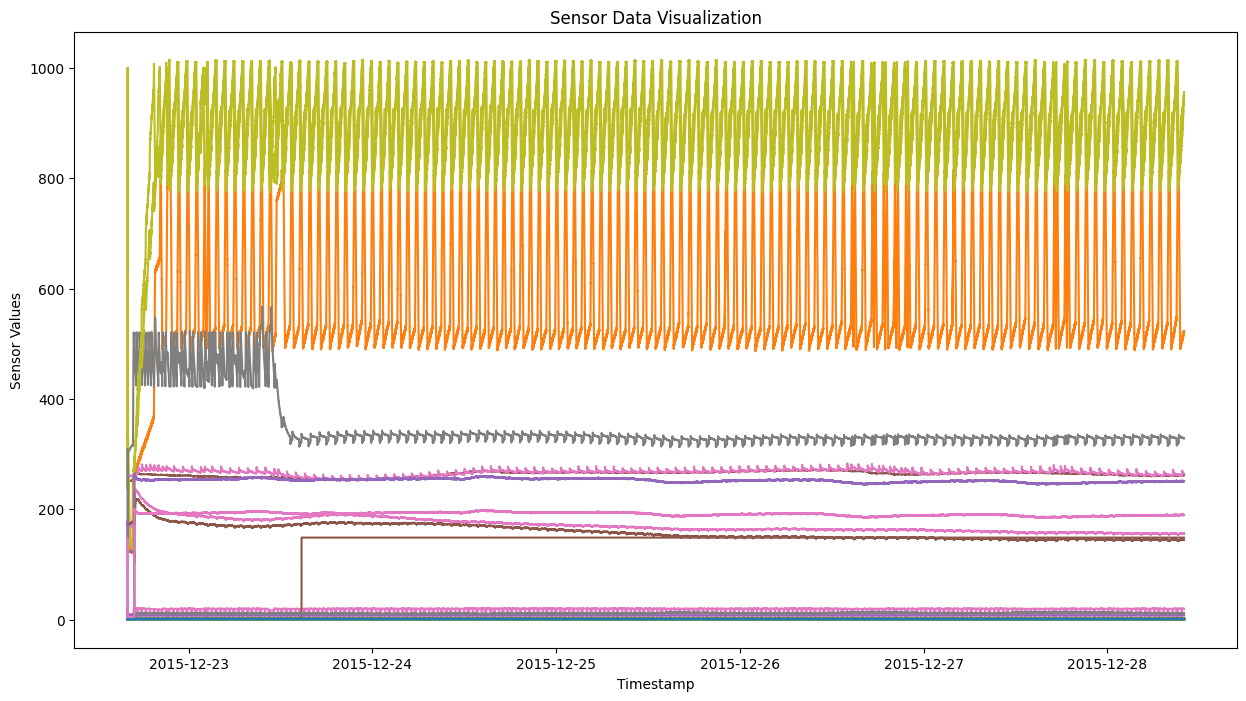

In [17]:
visualize_sensor_data(var)
visualize_sensor_data(train_data)

When plotting the data, we can see that, compared to the train data, now there are diagonal lines in places where anomalies occur. That's because the (anomalous) data at those points in time have been removed. This results in an overall cleaner resulting dataset.

#### What about the test data?
Now, we can use the cleaner dataset to detect anomalies in the test data.

In [18]:
#This cell should take ~3-4 minutes max to run. It will no longer plot intermediary steps, but print things at key points during the program execution.
onTest = PCA_for_anomaly_detection(var,test_data,5,120,False)

fixed dfs
applied pca


100%|██████████| 449919/449919 [00:51<00:00, 8652.55it/s]


calculated mse


100%|██████████| 449919/449919 [00:00<00:00, 4857005.13it/s]


Let us compare again the difference between the normal data and the one with anomalies removed. 

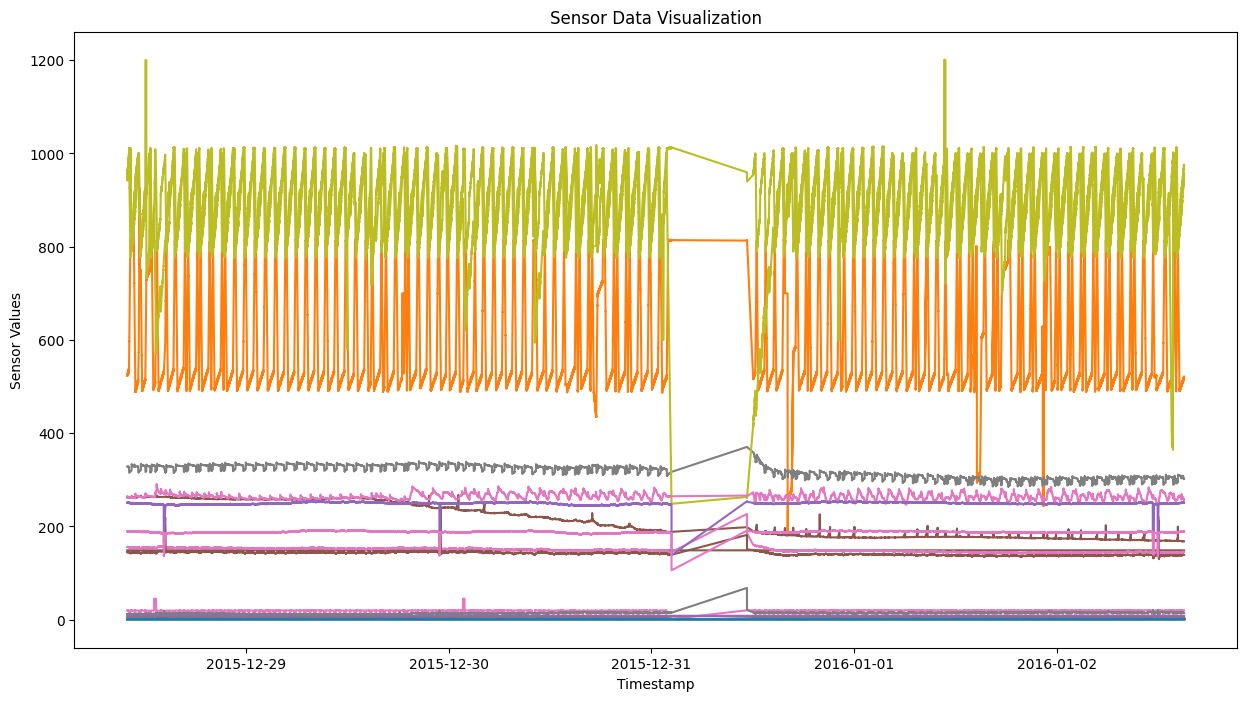

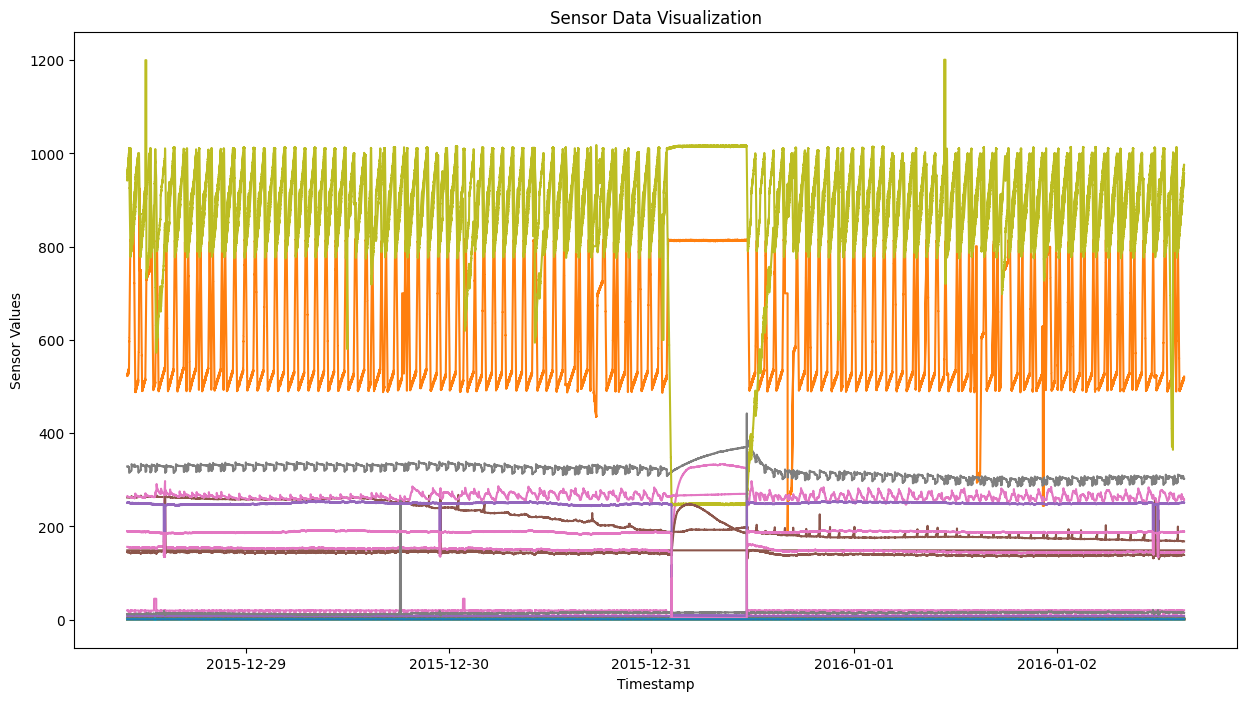

In [20]:
visualize_sensor_data(onTest)
visualize_sensor_data(test_data)

As you can see, during the moments where all sensors were attacked, the PCA algorithm has detected them as anomalous and removed them from the dataset.

## What kinds of anomalies can PCA detect?

PCA excels and detecting point anomalies. PCA has the ability to detect the underlying structure of the data which helps it in identifying points that are far from the main distribution (which are, most likely, anomalies).